In [1]:
from pathlib import Path
import pandas as pd
import numpy as np

import seaborn as sns
import geopandas as gpd
from scipy.stats import pearsonr
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import r2_score, mean_squared_error

In [36]:
#---------------------------------------------------
# for plotting purposes we use this iPython magic
%matplotlib inline
%pylab inline
pylab.rcParams['figure.figsize'] = (19, 19)

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [19]:
explain_vars = [
    "doy",
    "LIA",
    "VH",
    "VV",
    "VVVH_ratio",
    "angle",
    "sm_1",
    "sm_3",
    "sm_7",
    "sm_30",
    "precipitation",
    "prec_3",
    "prec_7",
    "prec_30",
    "elevation",
    "aspect",
    "slope",
    "land_cov",
    "canopy_height",
    "gldas_mean",
    "gldas_stddev",
    "B3",
    "B4",
    "B5",
    "B7",
    "ndvi",
    "ndmi",
    "ndbri",
    "doy"
]
response_var = ["gwl_cm"]
len(explain_vars)

29

In [30]:
explanatory_file_path = "data/7_training_data/High_corr_explanatory_with_response_var.csv"
df = pd.read_csv(explanatory_file_path)
df.head()

,id,date,gwl_cm,lat,lon,LIA,VH,VV,VVVH_ratio,angle,...,gldas_mean,gldas_stddev,B3,B4,B5,B7,ndvi,ndmi,ndbri,doy
0,BRG_150710_02,2018-11-13,-13.700,-1.190497,103.674229,38.987480,-12.457965,-7.130818,0.136825,38.270214,...,31.572474,2.53092,21,88,83,39,0.614679,0.029240,0.385827,317
1,BRG_150710_02,2018-11-13,-0.507,-1.190497,103.674229,38.987480,-12.457965,-7.130818,0.136825,38.270214,...,31.572474,2.53092,21,88,83,39,0.614679,0.029240,0.385827,317
2,BRG_150710_02,2018-11-14,-9.800,-1.190497,103.674229,35.520496,-12.991472,-6.993996,0.149585,36.642384,...,31.572474,2.53092,21,88,83,39,0.614679,0.029240,0.385827,318
3,BRG_150710_02,2018-11-14,-0.468,-1.190497,103.674229,35.520496,-12.991472,-6.993996,0.149585,36.642384,...,31.572474,2.53092,21,88,83,39,0.614679,0.029240,0.385827,318
4,BRG_150710_02,2019-01-12,17.800,-1.190497,103.674229,38.987246,-12.085230,-7.227125,0.127490,38.270000,...,31.572474,2.53092,20,69,74,33,0.550562,-0.034965,0.352941,12


In [21]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split


In [32]:
df

,id,date,gwl_cm,lat,lon,LIA,VH,VV,VVVH_ratio,angle,...,gldas_mean,gldas_stddev,B3,B4,B5,B7,ndvi,ndmi,ndbri,doy
0,BRG_150710_02,2018-11-13,-13.700,-1.190497,103.674229,38.987480,-12.457965,-7.130818,0.136825,38.270214,...,31.572474,2.530920,21,88,83,39,0.614679,0.029240,0.385827,317
1,BRG_150710_02,2018-11-13,-0.507,-1.190497,103.674229,38.987480,-12.457965,-7.130818,0.136825,38.270214,...,31.572474,2.530920,21,88,83,39,0.614679,0.029240,0.385827,317
2,BRG_150710_02,2018-11-14,-9.800,-1.190497,103.674229,35.520496,-12.991472,-6.993996,0.149585,36.642384,...,31.572474,2.530920,21,88,83,39,0.614679,0.029240,0.385827,318
3,BRG_150710_02,2018-11-14,-0.468,-1.190497,103.674229,35.520496,-12.991472,-6.993996,0.149585,36.642384,...,31.572474,2.530920,21,88,83,39,0.614679,0.029240,0.385827,318
4,BRG_150710_02,2019-01-12,17.800,-1.190497,103.674229,38.987246,-12.085230,-7.227125,0.127490,38.270000,...,31.572474,2.530920,20,69,74,33,0.550562,-0.034965,0.352941,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6419,kalteng1,2020-02-24,-0.239,-2.319728,114.058131,32.478706,-12.878587,-8.271499,0.097345,34.185207,...,31.701403,3.461483,19,81,53,21,0.620000,0.208955,0.588235,55
6420,kalteng1,2020-03-07,-0.311,-2.319728,114.058131,32.478589,-13.078360,-6.593164,0.169898,34.185097,...,31.701403,3.461483,19,81,53,21,0.620000,0.208955,0.588235,67
6421,kalteng1,2020-03-19,-0.147,-2.319728,114.058131,32.479968,-12.563061,-7.793232,0.110794,34.186478,...,31.701403,3.461483,19,81,53,21,0.620000,0.208955,0.588235,79
6422,kalteng1,2020-03-31,-0.271,-2.319728,114.058131,32.480674,-13.179518,-7.523130,0.128794,34.187180,...,31.701403,3.461483,19,81,53,21,0.620000,0.208955,0.588235,91


In [44]:
# group by id and get the number of dates for each id
df_grouped = df.groupby("id").count().reset_index()
df_grouped = df_grouped[["id", "date"]]
df_grouped.columns = ["id", "date_count"]
df_grouped


,id,date_count
0,103_GBSM_61,4
1,10_MTI_MTI_H176_P1,11
2,10_MTI_MTI_H176_P4,11
3,10_MTI_MTI_K085_P3,8
4,10_MTI_MTI_K085_P4,6
5,121_APC_D15,71
6,121_APC_H09,42
7,15_RAPP_TP-I-53,84
8,15_RAPP_TP-V-11,86
9,15_RAPP_TP-VI-56,15


In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 250, 500],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['mse', 'friedman_mse']
}
variable = 'gwl_cm'
temporal_expl = [
    'VV', 'VH', 'VVVH_ratio', 
    'precipitation', 'prec_3', 'prec_7', 'prec_30', 
    'sm_1',  'sm_3', 'sm_7', 'sm_30'
]
row = {}

for station_id in df['id'].unique():

    train_data = df[df['id'] != station_id]
    test_data = df[df['id'] == station_id]
    X_train, X_test = train_data[explain_vars], test_data[explain_vars]
    y_train, y_test = train_data[variable], test_data[variable]

    regr = RandomForestRegressor(random_state=42, oob_score=True, n_jobs=-1)
    grid_search = GridSearchCV(estimator=regr, param_grid=param_grid, cv=3)
    grid_search.fit(X_train, y_train)
    best_regr = grid_search.best_estimator_
    
    y_pred = best_regr.predict(X_test)

    r, _ = pearsonr(test_data[variable].values, y_pred)
    correlations = [r]
    correlations.extend([test_data[variable].corr(test_data[expl]) for expl in temporal_expl])
    row[station_id] = correlations

stats_df = pd.DataFrame.from_dict(row, orient='index')


In [34]:

row = {}

for i, station_id in enumerate(df.id.unique()):
    
    
    # add first element gwl-smm correlation to station_id
    explans = []
    
    # create a df for training without the station_id
    gdf_train = df[df.id != station_id]
    
    # create a df for test of the station_id
    gdf_test = df[df.id == station_id]
        
    X_train, X_test = gdf_train[explain_vars], gdf_test[explain_vars]
    y_train, y_test = gdf_train[variable], gdf_test[variable]
    
    regr = RandomForestRegressor(n_estimators=250, min_samples_leaf=1, random_state=42, oob_score=True, criterion='friedman_mse', n_jobs=-1)
    regr.fit(X_train, y_train)
    y_pred_test = regr.predict(X_test)
    
    r, p = pearsonr(gdf_test[variable].values, y_pred_test)
    explans.append(r)
    
    #r2 = r2_score(y_test, y_pred_test)
    #explans.append(r2)
    
    # add correlation of explanatories
    for expl in temporal_expl:
        explans.append(gdf_test[variable].corr(gdf_test[expl]))
        
    row[station_id] = explans
    
stats_df = pd.DataFrame.from_dict(row, orient='index')

In [40]:
stats_df.columns = ["friedman_mse"] + temporal_expl

<Axes: >

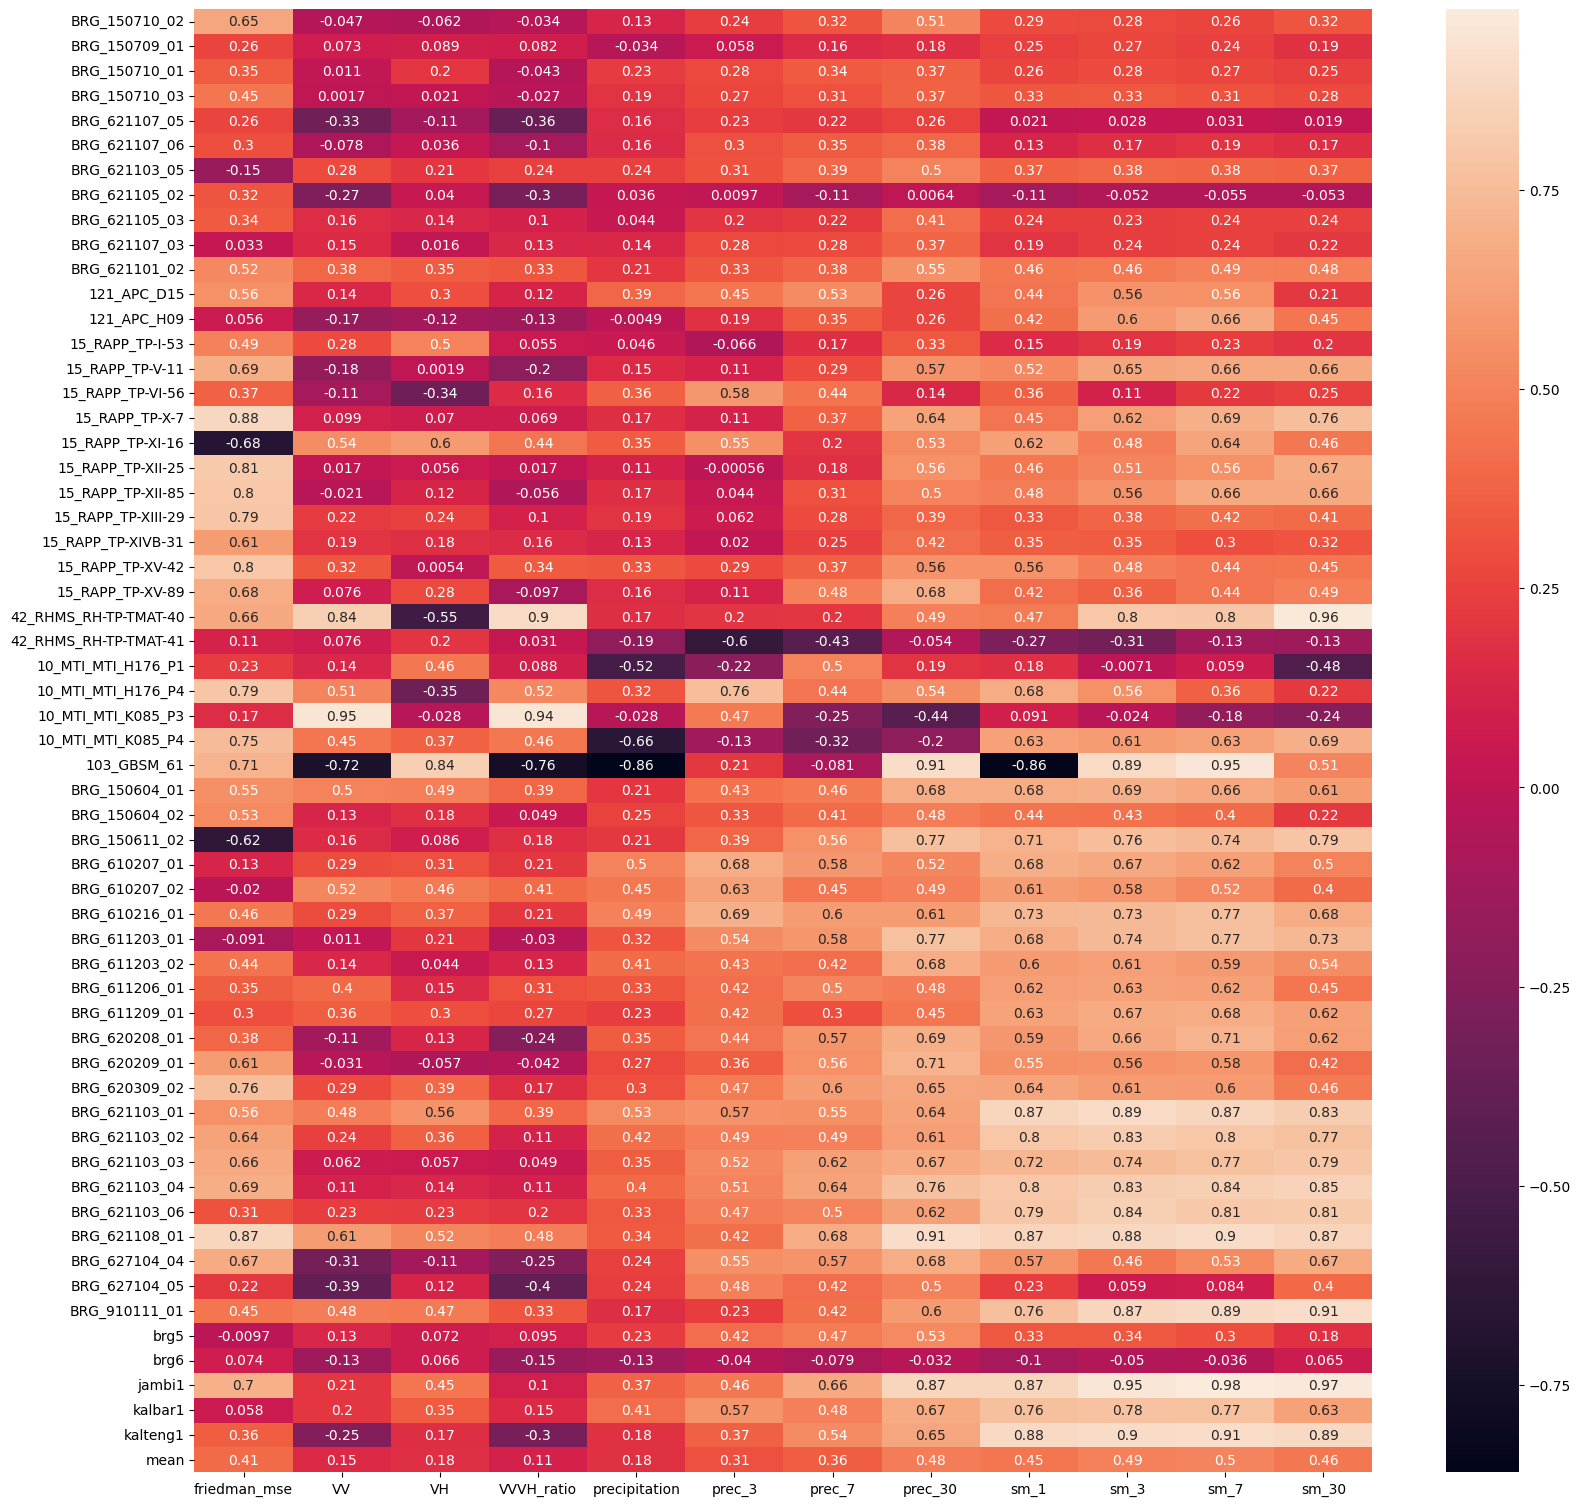

In [41]:
stats_df.loc['mean'] = stats_df.mean()
sns.heatmap(stats_df, annot=True)
#plt.savefig('figures/correlations/correlation_gwl_clean_trusted.png')